# The Ultimate Algo Trader (Neurobot 1.0)

## Introduction:
This jupyter notebook contains code for developing and testing a dynamic algorithmic trader based on Python and Machine learning strategy.

## Steps:
1. **Data preperation**: Access historical market data via Alpaca API and preprocess it for analysis.
2. **Strategy creation**: Code algorithmic trading strategy based on "TBD".
3. **Backtesting-Optimization**: Backtest the strategy using historical data and fine-tune parameters for better performance.
4. **Risk/Reward**: Calculate both the risk and the reward based on the entry price, position size, stop-loss and target price
5. **live Trading(Optional)**: Implement the strategy for paper trading on Alpaca.

**Tools and Libaries** 
- Python, Pandas, Numpy, "TBD"

#### Notes: 
- This notebook is for educational and experimental purposes only.

### Imports and Dependencies

In [1]:
import os
import numpy as np
import random
import datetime
import seaborn as sns
import pandas as pd
import yfinance as yf
import hvplot.pandas
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from scipy.interpolate import interp1d
from alpaca_trade_api.rest import REST, TimeFrame
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error


# Initialize python files and import functions
import stock_data as data
import algo_strategy as strategy
import nn_models as model
import backtesting as backtest

import warnings
warnings.filterwarnings('ignore')

#!pip install pandas-ta
import pandas_ta as ta
import plotly.graph_objs as go

In [2]:
load_dotenv()

True

### Data Processing and collection

In [3]:
# Fetch list of tickers
# Get select top picks based on monthly highest performing stocks in sp500 
#ticker_list = data.get_clusters_from_sp500(sp500_url = os.getenv("SP500_URL"))

# fetch_stock_data based on top picks from ticker_list
stock_data = data.fetch_stock_data('2018-01-12', '2024-03-14', tickers= ['NVDA'], timeframe='1Day')

In [4]:
# data cleaning and organization
stock_df = stock_data #.rename(columns={'NVDA': 'NVDA close'})
stock_df['Daily Returns'] = stock_df['NVDA']['close'].pct_change()
stock_df = stock_df.dropna()
stock_df

NVDA                                     Daily Returns
               open   close    high     volume      low              
timestamp                                                            
2018-01-16  224.050  220.11  227.51   17986928  216.690     -0.011892
2018-01-17  220.700  224.72  225.12   13942387  216.900      0.020944
2018-01-18  223.940  224.44  226.64   10756754  222.680     -0.001246
2018-01-19  228.090  230.11  231.09   15935244  227.000      0.025263
2018-01-22  230.430  233.69  233.76   14260753  228.100      0.015558
...             ...     ...     ...        ...      ...           ...
2024-03-08  951.379  875.28  974.00  113705642  865.060     -0.055477
2024-03-11  864.290  857.74  887.97   67836412  841.660     -0.020039
2024-03-12  880.490  919.13  919.60   66807515  861.501      0.071572
2024-03-13  910.550  908.88  915.04   63571289  884.350     -0.011152
2024-03-14  895.770  879.44  906.46   60231816  866.000     -0.032392

[1551 rows x 6 columns]

#### Feauture Engineering - Time series Analysis

In [5]:
stock_df['Cumulative Returns'] = (1 + stock_df['Daily Returns']).cumprod()
stock_df['Daily Returns Lagged'] = stock_df['Daily Returns'].shift(-1)

# set window sizes based on strategy
short_window = 5
long_window = 100

stock_df['SMA_Fast'] = stock_df['NVDA']['close'].rolling(window=short_window).mean()
stock_df['SMA_Slow'] = stock_df['NVDA']['close'].rolling(window=long_window).mean()
stock_df["EMA_Fast"] = stock_df['NVDA']["close"].ewm(span=short_window).mean()
stock_df["EMA_Fast"] = stock_df['NVDA']["close"].ewm(span=long_window).mean()
stock_df = stock_df.dropna()

# later on -> trial different training windows using DateOffset()

Bollinger Bands
A Bollinger Band is a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the Stocks’ price Bollinger Bands allow traders to monitor and take advantage of shifts in price volatilities

Main Components of a Bollinger Bands

Upper Band: The upper band is simply two standard deviations above the moving average of a stock’s price.
Middle Band: The middle band is simply the moving average of the stock’s price.
Lower Band: Two standard deviations below the moving average is the lower band.

In [6]:
#adding close, high & low 
stock_df['close'] = stock_df['NVDA']['close']
stock_df['high'] = stock_df['NVDA']['high']
stock_df['low'] = stock_df['NVDA']['low']

df_stock = stock_df.drop(columns='NVDA').reset_index()

In [7]:
df_stock.rename(columns={'timestamp': 'Date'}, inplace=True)

In [8]:
df_stock.head()

,Date,Daily Returns,Cumulative Returns,Daily Returns Lagged,SMA_Fast,SMA_Slow,EMA_Fast,close,high,low
,,,,,,,,,,
0,2018-06-07,-0.008486,1.180199,-0.002358,263.118,238.5978,241.561182,262.90,265.4785,259.250
1,2018-06-08,-0.002358,1.177416,-0.006329,264.050,239.0195,242.034200,262.28,264.0000,259.200
2,2018-06-11,-0.006329,1.169964,0.007521,263.204,239.3785,242.457239,260.62,263.4500,260.100
3,2018-06-12,0.007521,1.178763,-0.000686,262.706,239.7599,242.913910,262.58,263.0700,259.660
4,2018-06-13,-0.000686,1.177955,0.017188,262.156,240.0828,243.354857,262.40,265.6700,262.031


In [12]:
df_stock[['dcl', 'dcm', 'dcu']] = df_stock.ta.donchian(lower_length = 40, upper_length = 50)
df_stock = df_stock.dropna()
df_stock = df_stock.set_index('Date')
df_stock.index = pd.to_datetime(df_stock.index)

df_stock.head()

,Daily Returns,Cumulative Returns,Daily Returns Lagged,SMA_Fast,SMA_Slow,EMA_Fast,close,high,low,dcl,dcm,dcu,SMA,SD,UB,LB
,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2019-01-08,-0.024895,0.627719,0.019667,136.726,213.5710,192.987665,139.83,146.78,136.90,124.46,173.23,222.0,139.0040,7.761177,154.526354,123.481646
2019-01-09,0.019667,0.640064,0.018586,137.998,212.4060,191.982445,142.58,144.49,139.86,124.46,173.23,222.0,138.5400,7.209959,152.959918,124.120082
2019-01-10,0.018586,0.651960,0.024788,141.446,211.2839,191.050248,145.23,145.58,139.36,124.46,173.23,222.0,138.3920,7.029570,152.451139,124.332861
2019-01-11,0.024788,0.668121,0.010818,143.974,210.3240,190.208533,148.83,149.75,143.21,124.46,173.23,222.0,138.3885,7.024078,152.436655,124.340345
2019-01-14,0.010818,0.675349,-0.003789,145.382,209.3500,189.415802,150.44,151.46,145.77,124.46,173.23,222.0,138.4660,7.153404,152.772809,124.159191


In [13]:
# Calculating Don Chaian 

df_stock[['dcl', 'dcm', 'dcu']] = df_stock.ta.donchian(lower_length = 40, upper_length = 50)
df_stock = df_stock.dropna()
#df_stock = df_stock.set_index('Date')
df_stock.index = pd.to_datetime(df_stock.index)

# Calculating Bollinger Band use an time interval (1 D time interval)

# Calculate the 20-period Simple Moving Average (SMA)
df_stock['SMA'] = df_stock['close'].rolling(window=20).mean()

# Calculate the 20-period Standard Deviation (SD)
df_stock['SD'] = df_stock['close'].rolling(window=20).std()

# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
df_stock['UB'] = df_stock['SMA'] + 2 * df_stock['SD']
df_stock['LB'] = df_stock['SMA'] - 2 * df_stock['SD']

df_stock.dropna().head()



,Daily Returns,Cumulative Returns,Daily Returns Lagged,SMA_Fast,SMA_Slow,EMA_Fast,close,high,low,dcl,dcm,dcu,SMA,SD,UB,LB
,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2019-04-16,0.019004,0.844904,-0.004888,189.312,156.8581,174.510060,188.21,188.97,184.9641,144.8,169.135,193.47,184.0260,6.358218,196.742437,171.309563
2019-04-17,-0.004888,0.840774,-0.005286,188.350,157.2402,174.763584,187.29,190.46,186.3900,144.8,169.135,193.47,184.6705,5.972737,196.615973,172.725027
2019-04-18,-0.005286,0.836330,0.011433,187.302,157.6561,174.992432,186.30,188.93,185.1800,144.8,169.135,193.47,184.7885,5.980852,196.750204,172.826796
2019-04-22,0.011433,0.845892,0.011888,186.986,158.0904,175.258983,188.43,189.10,184.0800,144.8,169.135,193.47,185.3350,5.775658,196.886316,173.783684
2019-04-23,0.011888,0.855947,0.002622,188.180,158.4666,175.564670,190.67,191.93,188.6100,144.8,169.135,193.47,186.1795,5.203677,196.586855,175.772145


In [25]:
period = 5

# Assuming df_stock is your DataFrame containing stock data
# Assuming short_window and period are defined variables

# Calculate the weighted moving average (WMA)
wma_values = df_stock['close'].ewm(alpha=1.0 / period, adjust=False).mean()

# Create a DataFrame to store the WMA values
wma_df = pd.DataFrame(index=df_stock.index, columns=['WMA'])

# Calculate the WMA for the initial period separately and append the rest
wma_initial = df_stock['close'].iloc[:period].mean()
wma_df.loc[df_stock.index[period - 1], 'WMA'] = wma_initial
wma_df['WMA'].iloc[period:] = wma_values[short_window:]

# Assign the calculated WMA DataFrame back to df_stock
df_stock['WMA'] = wma_df['WMA']

df_stock.head()

,Daily Returns,Cumulative Returns,Daily Returns Lagged,SMA_Fast,SMA_Slow,EMA_Fast,close,high,low,dcl,dcm,dcu,SMA,SD,UB,LB,WMA
,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2019-03-20,-0.007455,0.782909,0.054702,170.896,159.6355,169.631599,174.40,179.0300,173.0000,131.00,155.015,179.03,NaN,NaN,NaN,NaN,NaN
2019-03-21,0.054702,0.825735,-0.035011,174.572,159.4808,169.915682,183.94,185.0000,175.1300,131.00,158.000,185.00,NaN,NaN,NaN,NaN,NaN
2019-03-22,-0.035011,0.796825,-0.020958,176.110,159.1774,170.066254,177.50,184.7997,176.9400,131.00,158.000,185.00,NaN,NaN,NaN,NaN,NaN
2019-03-25,-0.020958,0.780126,0.017781,177.066,158.9323,170.139980,173.78,178.4500,171.1100,131.00,158.000,185.00,NaN,NaN,NaN,NaN,NaN
2019-03-26,0.017781,0.793997,-0.002092,177.298,158.8448,170.273579,176.87,181.7500,174.5969,131.01,158.005,185.00,NaN,NaN,NaN,NaN,177.298


In [45]:
def atr(df_stock, n=14):
    data = df_stock.copy()
    high = data['high']
    low = data['low']
    close = data['close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = tr.ewm(span=n, adjust=False).mean()  # Calculate the WMA of tr
    return atr

In [46]:
atr = atr(df_stock, n=14)


In [62]:
atr_df = pd.DataFrame(atr, columns = ['ATR'])

In [64]:
### Calculating CCI Comnodity Channel Index
p = 20
ma = (df_stock['close'])/p
mean_dev = (df_stock['close']-ma) / p
price = (df_stock['high'] + df_stock['low'] + df_stock['close'])/3

CCI = (price - ma)/(0.015*mean_dev)*price
CCI_df = pd.DataFrame(CCI, columns = ['CCI'])

In [71]:
feature_df = pd.concat([df_stock, CCI_df, atr_df], axis = 1)
feature_df.dropna()

,"(Daily Returns, )","(Cumulative Returns, )","(Daily Returns Lagged, )","(SMA_Fast, )","(SMA_Slow, )","(EMA_Fast, )","(close, )","(high, )","(low, )","(dcl, )","(dcm, )","(dcu, )","(SMA, )","(SD, )","(UB, )","(LB, )","(WMA, )",CCI,ATR
Date,,,,,,,,,,,,,,,,,,,
2019-04-16,0.019004,0.844904,-0.004888,189.312,156.8581,174.510060,188.21,188.97,184.9641,144.8000,169.1350,193.47,184.0260,6.358218,196.742437,171.309563,187.94275,2.486839e+05,4.841942
2019-04-17,-0.004888,0.840774,-0.005286,188.350,157.2402,174.763584,187.29,190.46,186.3900,144.8000,169.1350,193.47,184.6705,5.972737,196.615973,172.725027,187.8122,2.517952e+05,4.739016
2019-04-18,-0.005286,0.836330,0.011433,187.302,157.6561,174.992432,186.30,188.93,185.1800,144.8000,169.1350,193.47,184.7885,5.980852,196.750204,172.826796,187.50976,2.497795e+05,4.607147
2019-04-22,0.011433,0.845892,0.011888,186.986,158.0904,175.258983,188.43,189.10,184.0800,144.8000,169.1350,193.47,185.3350,5.775658,196.886316,173.783684,187.693808,2.478940e+05,4.662194
2019-04-23,0.011888,0.855947,0.002622,188.180,158.4666,175.564670,190.67,191.93,188.6100,144.8000,169.1350,193.47,186.1795,5.203677,196.586855,175.772145,188.289046,2.534974e+05,4.507235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-07,0.044746,4.160056,-0.055477,869.698,557.9234,599.209403,926.69,927.67,896.0201,534.8900,731.2800,927.67,774.5085,68.513262,911.535024,637.481976,842.310237,1.208649e+06,35.162371
2024-03-08,-0.055477,3.929269,-0.020039,880.196,562.1301,604.676148,875.28,974.00,865.0600,535.6000,754.8000,974.00,783.4520,69.450122,922.352244,644.551756,848.904189,1.249172e+06,44.999389
2024-03-11,-0.020039,3.850529,0.071572,881.270,566.0980,609.687313,857.74,887.97,841.6600,543.3008,758.6504,974.00,790.2725,69.725873,929.724246,650.820754,850.671351,1.156599e+06,45.174137


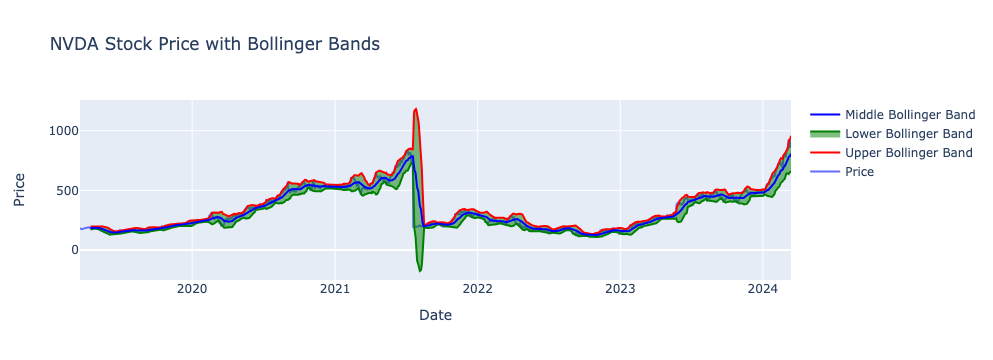

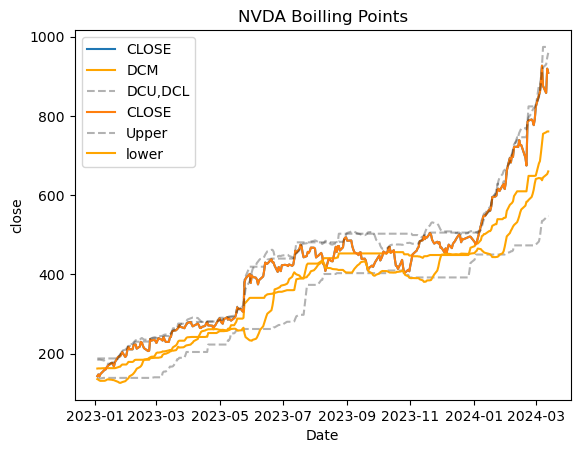

In [14]:
#plot NVDA DONCHIAN CHANNELS 50
plt.plot(df_stock[-300:].close, label = 'CLOSE')
plt.plot(df_stock[-300:].dcl, color = 'black', linestyle = '--', alpha = 0.3)
plt.plot(df_stock[-300:].dcm, color = 'orange', label = 'DCM')
plt.plot(df_stock[-300:].dcu, color = 'black', linestyle = '--', alpha = 0.3, label = 'DCU,DCL')
plt.legend()
plt.title('NVDA DONCHIAN CHANNELS 50')
plt.xlabel('Date')
plt.ylabel('close')

#plot NVDA Boiling Point
plt.plot(df_stock[-300:].close, label = 'CLOSE')
plt.plot(df_stock[-300:].UB, color = 'black', linestyle = '--', alpha = 0.3, label = 'Upper')
plt.plot(df_stock[-300:].LB, color = 'orange', label = 'lower')
plt.legend()
plt.title('NVDA Boilling Points')
plt.xlabel('Date')
plt.ylabel('close')


# Create a Plotly figure
fig = go.Figure()

# Add the price chart
fig.add_trace(go.Scatter(x=df_stock.index, y=df_stock['close'], mode='lines', name='Price'))

# Add the Upper Bollinger Band (UB) and shade the area
fig.add_trace(go.Scatter(x=df_stock.index, y=df_stock['UB'], mode='lines', name='Upper Bollinger Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_stock.index, y=df_stock['LB'], fill='tonexty', mode='lines', name='Lower Bollinger Band', line=dict(color='green')))

# Add the Middle Bollinger Band (MA)
fig.add_trace(go.Scatter(x=df_stock.index, y=df_stock['SMA'], mode='lines', name='Middle Bollinger Band', line=dict(color='blue')))

# Customize the chart layout
fig.update_layout(title='NVDA Stock Price with Bollinger Bands',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  showlegend=True)

# Show the chart
fig.show()

In [ ]:
buy_points = (signals_df['SMA50'] > signals_df['SMA100']) & (signals_df['SMA50'].shift(1) <= signals_df['SMA100'].shift(1))
sell_points = (signals_df['SMA50'] < signals_df['SMA100']) & (signals_df['SMA50'].shift(1) >= signals_df['SMA100'].shift(1))
all_cross_points = buy_points | sell_points # bit wise

#checking this first cross over
first_crossover = buy_points.idxmax() 
first_crossover

signals_df['Signal'] = np.where((signals_df['SMA50'] > signals_df['SMA100']) & (signals_df.index >= first_crossover), 1, 0)
signals_df

buy_indices = np.where(buy_points)[0]
buy_indices
sell_indices = np.where(sell_points)[0]
sell_indices
signals_df

### Algorithim Buy/Sell  Best signal selection

In [ ]:
# Initialize Signals 
signals = {
    "signal_one": strategy.strategy_one(stock_data),
    "signal_two": strategy.strategy_two(stock_data),
    "signal_three": strategy.strategy_three(stock_data),
    "signal_four": strategy.strategy_four(stock_data),
    "signal_five": strategy.strategy_five(stock_data) }

# Function for simple winning trading strategy 
def simple_winning(signals):
    best_strategy = max(signals, key=signals.get)
    winning_signal = signals[best_strategy]
    return winning_signal

# Function for strategy that combines signals using a majority vote
def majority_vote(signals):
    buy_signal = sum(1 for signal in signals.values() if signal == 1)    # "Buy"
    sell_signal = sum(1 for signal in signals.values() if signal == -1)  # "Sell"
    return 1 if buy_signal > sell_signal else -1 if sell_signal > buy_signal else 0  # "Buy", "Sell", or "Hold"

# Add signals to stock_df
stock_df['Majority_vote'] = majority_vote(signals)
stock_df['Simple_winning'] = simple_winning_(signals)

# Plot winning signal and hybrid


### Machine Learning Best Model Selection

In [ ]:
# Initialize Models
models = {
    "model_one": model.model_one(),
    "model_two": model.model_two(),
    "model_three": model.model_three(),
    "model_four": model.model_four(),
    "model_five": model.model_five() }

def select_best_model(models, X_train, y_train):
    # Define initial best score and best model
    best_model_name = None
    best_model = None
    best_accuracy = 0.0
    best_mse = float('inf')
    all_scores = {}
    all_mses = {}
    
    # Define the scoring metrics you want to use
    scoring = ['accuracy', 'precision', 'recall', 'f1_score']
    
    # Train and evaluate each model using cross-validation
    for name, model in models.items():
       
        metric_scores = {}
        
        # Evaluate model using cross-validation for each scoring metric
        for metric in scoring:
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
            
            metric_scores[metric] = scores
            
        # Calculate the mean scores
        mean_scores = {metric: scores.mean() for metric, scores in metric_scores.items()}
        mse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        mean_mse = mse_scores.mean()
        
        # Store the scores for the current model
        all_scores[name] = metric_scores
        all_mses[name] = mse_scores
        
        # Update best model if current model performs better based on accuracy or MSE
        if mean_mse < best_mse or (mean_mse == best_mse and mean_scores['accuracy'] > best_accuracy):
            best_accuracy = mean_scores['accuracy']
            best_mse = mean_mse
            best_model_name = name
            best_model = model
    
    return best_model_name, best_model, all_scores, all_mses

best_model_name, best_model, all_scores, all_mses = select_best_model(models, X_train, y_train)


### Backtesting - Best Model and Best Strategy

### Fundamental Analysis (Predictions and Plotting)

In [ ]:
stock_df[['Daily Returns Lagged', 'Daily Returns']].corr()

# maybe not to use lagged strategy 
# consider DMAC? 

In [ ]:
stock_df['Cumulative Returns'].plot()

In [ ]:
# Print the selected best model name
print("Selected Best Model:", best_model_name)

# Print the cross-validation scores for each model and each metric
for name, scores in all_scores.items():
    print("Model:", name)
    for metric, metric_scores in scores.items():
        print(f"Mean {metric.capitalize()} Score:", metric_scores.mean())

# Print the cross-validation MSE scores for each model
for name, mse_scores in all_mses.items():
    print("Model:", name)
    print("Cross-Validation MSE Scores:", mse_scores)

### Risk management and Rewards

### Logic to place trade (Optional)

In [ ]:
# From Algo Trading 3 live 

# Submit order
api.submit_order(
    symbol="META", 
    qty=number_of_shares, 
    side=orderSide, 
    time_in_force="gtc", 
    type="limit", 
    limit_price=limit_amount
